# Analysis of the toilet visit time distribution

The main question is which distribution is most suitable to model the toilet visit times given the emperical data?

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import scipy.stats as stats
import openturns as ot
from math import ceil

### Import data

In [2]:
filename = Path('./data/processed/20210818_evening_toilet_visits.csv')
df = pd.read_csv(filename, parse_dates=['start_time', 'end_time'])
visit_times = df['visit_time'][df['visit_time'].notnull()]

### Plot histogram for several bin counts

The plot shows that, regardless of the bin count:
- the visit times range from 18 seconds (probably just washing hands) to 438 seconds
- the bulk is between 60 seconds and +- 160 seconds 
- the distribution is skewed to the left with a long right tail

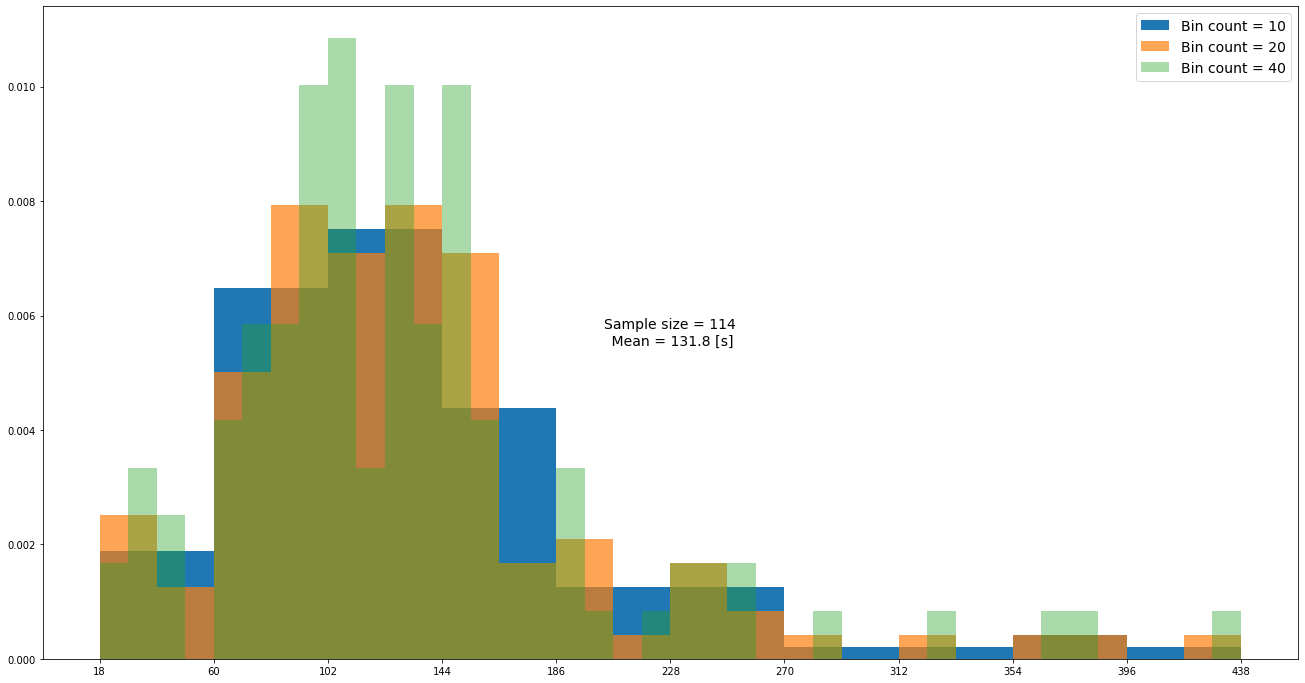

In [3]:
plt.rcParams['figure.figsize'] = [22.5,12]

bin_counts = [10, 20, 40]
alpha_step = 0.6/(len(bin_counts) - 1)
for ii, bin_count in enumerate(bin_counts):
    hist = plt.hist(visit_times, bins=bin_count, density=True, label=f'Bin count = {bin_count}', alpha=1-ii*alpha_step)
    if ii == 0:
        x = hist[1]

plt.xticks(x)
plt.text(0.5,0.5, f'Sample size = {len(visit_times)}\n Mean = {np.mean(visit_times):.1f} [s]', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes, fontsize=14)
leg = plt.legend(fontsize=14)

### Fit the openturns distributions and determine the goodness-of-fit of the different fitted distributions


In [4]:
%%capture --no-stdout

def process_line(line):
    line = line.strip()
    start_ind = 0
    parts = []
    for ii in range(3):
        comma_index = line.find(',', start_ind)
        value = line[start_ind:comma_index].strip()
        if ii == 1 or ii == 2:
            value = float(value)        
        start_ind = comma_index + 1
        parts.append(value)
        
    parts.append(ast.literal_eval(line[start_ind:].strip()))
    return parts

scipy_2_ot_distr = {
    'arcsine': 'ArcsineFactory',
    'beta': 'BetaFactory',
    'burr': 'BurrFactory',
    'chi': 'ChiFactory',
    'chi2': 'ChiSquareFactory',
    'expon': 'ExponentialFactory',
    'invweibull': 'FrechetFactory',
    'gamma': 'GammaFactory',
    'pareto': 'ParetoFactory',
    'genpareto': 'GeneralizedParetoFactory',
    'weibull_max': 'WeibullMaxFactory',
    'genextreme': 'GeneralizedExtremeValueFactory',
    'gumbel_r': 'GumbelFactory',
    'invgauss': 'InverseNormalFactory',
    'laplace': 'LaplaceFactory',
    'logistic': 'LogisticFactory',
    'lognorm': 'LogNormalFactory',
    'loguniform': 'LogUniformFactory',
    'norm': 'NormalFactory',
    'rayleigh': 'RayleighFactory',
    't': 'StudentFactory',
    'trapezoid': 'TrapezoidalFactory',
    'truncnorm': 'TruncatedNormalFactory',
    'uniform': 'UniformFactory',
    'vonmises': 'VonMisesFactory',
    'weibull_min': 'WeibullMinFactory',
}


with open(Path('./data/stats/toilet_fits.txt'), 'r') as f:
    lines = [process_line(line) for line in f if '#' not in line]

min_value = min(visit_times)
max_value = max(visit_times)    

y, x = np.histogram(visit_times, bins=10, density=True)
bin_size = x[1] - x[0]
x = x[1:] - bin_size

visit_times_np = np.array(visit_times)
visit_times_ot = ot.Sample(np.expand_dims(visit_times_np, axis=1))

distrs = []
name_length_max = 0
for ii, distr_data in enumerate(lines):
    res = stats.cramervonmises(visit_times, distr_data[0], args=distr_data[3])
    dist = getattr(stats, distr_data[0])(*distr_data[3])
    y_dist = dist.pdf(x)    
    try:
        r, p_pearson = stats.pearsonr(y, y_dist)   
    except:
        r = np.nan
        p_pearson = np.nan
        
    if distr_data[0] in scipy_2_ot_distr:
        factory = getattr(ot, scipy_2_ot_distr[distr_data[0]])
        ot_dist = factory().build(visit_times_ot)
        res_ot = stats.cramervonmises_2samp(visit_times_np, np.array(ot_dist.getSample(1000000)).flatten())
        ot_cvm_p_val = res_ot.pvalue
        try:
            truncated = ot.TruncatedDistribution(ot_dist, min_value, max_value)
            res_ot = stats.cramervonmises_2samp(visit_times_np, np.array(truncated.getSample(1000000)).flatten())
            ot_trunc_cvm_p_val = res_ot.pvalue
            ot_trunc_dist = truncated      
        except:
            #print(distr_data[0])
            ot_trunc_cvm_p_val = -1
            ot_trunc_dist = None
    else:
        ot_cvm_p_val = -1
        ot_dist = None
        ot_trunc_cvm_p_val = -1
        ot_trunc_dist = None
        
    distrs.append((distr_data[0], distr_data[2], res.pvalue, distr_data[3], r, p_pearson, 
                   ot_cvm_p_val, ot_dist, ot_trunc_cvm_p_val, ot_trunc_dist))
    
    if len(distr_data[0]) > name_length_max:
        name_length_max = len(distr_data[0])

distrs.sort(key=lambda el: (el[8], el[6], el[2]), reverse=True)        
    
#print(f'{"name":>{name_length_max}s} - {"ks":>6s} - {"cvm":>6s} - p - {"pear_r":>6s} - {"pear_p":>6s}')
#for name, ks_p_value, cvm_p_value, params, r, p_pearson in distrs:    
#    print(f'{name:>{name_length_max}s} - {ks_p_value:.4f} - {cvm_p_value:.4f} - {len(params)} - {r:.4f} - {p_pearson:.4f}')

### Plots showing the fit of the distributions, truncated using a minimum an maximum value based on the data

The plots below show all the continuous distributions from the scipy package which could be fitted to the data. Per plot the following elements are shown:
1. The distribution of the data in the form of histograms using different bin counts
2. The pdf of the fitted scipy distribution
3. If available the pdf of the fitted openturn distribution
4. If available the pdf of the truncated version of the fitted openturn distribution
5. The p-value obtained using the Cramer-von-mises test indicating how well the distribution obtained using scipy fits the data (If p < 0.05 the null hypothesis that the distributions are drawn form the same "parent distribution "can be rejected at a 95% confidence level, i.e. the higher this value the better the fit)
6. The p-value obtained using the Cramer-von-mises test indicating how well the distribution obtained using openturns fits the data
7. The p-value obtained using the Cramer-von-mises test indicating how well the truncated distribution obtained using openturns fits the data
8. The Pearson's rank correlation value. This one was used by Yufei to estimate the fit and the sam method has been use here. However, firstly, as this is based on the fit of only 10 data points which makes it sensitive to the choice of these 10 points (they are extracted from the histogram) and secondly, the plots show it cannot make a clear distinction between the fit of the different distributions

The plot are sorted in order of 1) the p-value of the truncated distribution, 2) the p-value of the openturns distribution and 3) the p-value of the scipy distribution

Based on the plots a conclusion is drawn on which distributions form the best candidates for use in the model. This can be found below the plots.



C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(4.3128468).
  warnings.warn(
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:6893: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:6893: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:105: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


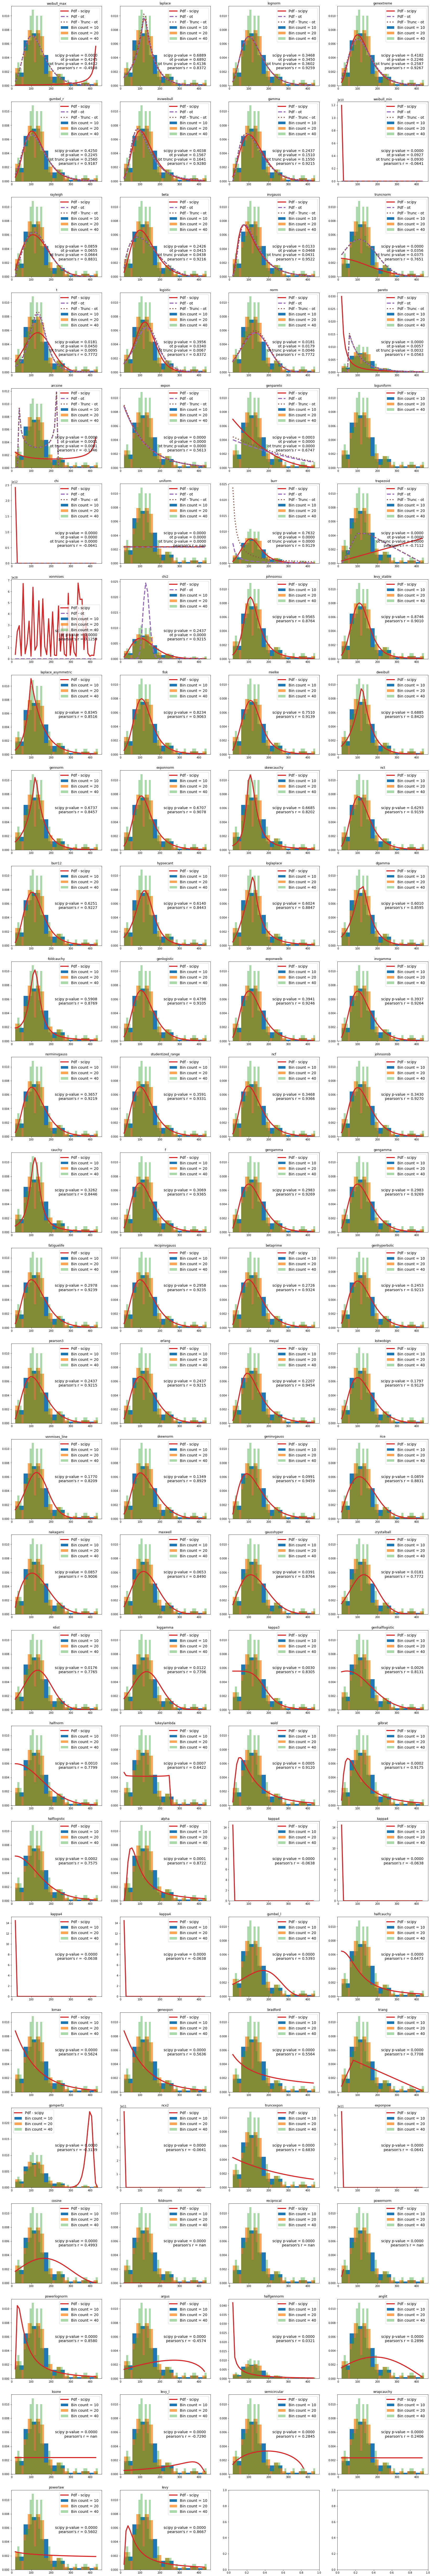

In [5]:
plt.rcParams['figure.figsize'] = [28.5,180]

col_count = 4
row_count = int(ceil(len(lines)/col_count))
_, axes = plt.subplots(row_count, col_count)

axes = axes.flatten()

import scipy.stats as stats

min_value = min(visit_times)
max_value = max(visit_times)

for ii, distr_data in enumerate(distrs):
    name, ks_p_value, cvm_p_value, params, p_r, p_p, ot_cvm_p_val, ot_dist, ot_trunc_cvm_p_val, ot_trunc_dist = distr_data
    for jj, bin_count in enumerate(bin_counts):
        hist = axes[ii].hist(visit_times, bins=bin_count, density=True, label=f'Bin count = {bin_count}', alpha=1-jj*alpha_step)
    
    dist = getattr(stats, name)(*params)
    x = np.arange(max(min_value, dist.ppf(0)), min(max_value,dist.ppf(1)), 10)
    x_ot = ot.Sample(np.expand_dims(x, axis=1))
    axes[ii].plot(x, dist.pdf(x), linewidth=4, label='Pdf - scipy')
    if ot_dist is not None:
        try:
            axes[ii].plot(x, np.array(ot_dist.computePDF(x_ot)), linewidth=4, linestyle='--', label='Pdf - ot')
            if ot_trunc_dist is not None:
                axes[ii].plot(x, np.array(ot_trunc_dist.computePDF(x_ot)), linewidth=4, linestyle=':', label='Pdf - Trunc - ot')
                axes[ii].text(0.95,0.3, f'scipy p-value = {cvm_p_value:.4f}\n ot p-value = {ot_cvm_p_val:.4f}\n ot trunc p-value = {ot_trunc_cvm_p_val:.4f}\n pearson\'s r = {p_r:.4f}', horizontalalignment='right', verticalalignment='center', transform = axes[ii].transAxes, fontsize=14)
            else:
                axes[ii].text(0.95,0.3, f'scipy p-value = {cvm_p_value:.4f}\n ot p-value = {ot_cvm_p_val:.4f}\n pearson\'s r = {p_r:.4f}', horizontalalignment='right', verticalalignment='center', transform = axes[ii].transAxes, fontsize=14)
        except:
            pass
    else:
        axes[ii].text(0.95,0.5, f'scipy p-value = {cvm_p_value:.4f}\n pearson\'s r = {p_r:.4f}', horizontalalignment='right', verticalalignment='center', transform = axes[ii].transAxes, fontsize=14)
    axes[ii].set_title(f'{name}')
    leg = axes[ii].legend(fontsize=14)
    


### Which distribution to use in the simulations?

1. A truncated distribution should be used both from a realism point of view (negative or zero second durations of toilet visits are not realistic) and from a practical point of view (the model cannot handle toilet visit durations that are smaller than or equal to 0 or very long)
2. The scipy package cannot provide a truncated distribution so for practical reasons a distribution should be chosen which is supported by the openturn package which does support truncated distributions

Based on the p-values the weibull_max laplace and lognormal distributions generally seems to provide the best fit. The weibull_max is not estimated well by the scipy package in this case and the non-truncated version also fits less well compared to the laplace distribution. However, the truncated version fits sligthly better than the truncated version of the laplace distribution.

Overall, the laplace distribution seems to provide a better overall fit (the clear peaks around the 2 mnute mark) and hence should be chosen to simulate the toilter visit times in the simulations




